In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch.nn.functional as F
from torch import nn, optim

import sys
sys.path.append("./../../")

from modules.dvae.model import DVAE
from modules.matcher.model import TrMatcher
from config_reader import ConfigReader
from datasets.mnist_loader import MNISTData
from notebooks.utils import show
from modules.common_utils import latent_to_img
from utilities.md_mnist_utils import LabelsInfo

In [2]:
from einops.layers.torch import Rearrange
from modules.common_blocks import TrEncoderBlock

In [3]:
class ImgEncoder(nn.Module):
    def __init__(self,
                 img_height,
                 img_width,
                 img_channels,
                 patch_height,
                 patch_width,
                 embed_dim,
                 num_blocks,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob,
                 device=torch.device('cpu')):
        super(ImgEncoder, self).__init__()
        self.device = device
        
        self.n_h_patch = img_height // patch_height
        self.n_w_patch = img_width // patch_width
        patch_dim = img_channels * patch_height * patch_width

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        self.img_pe_col = nn.Parameter(torch.randn(self.n_h_patch, 1, embed_dim))
        self.img_pe_row = nn.Parameter(torch.randn(self.n_w_patch, 1, embed_dim))
        
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, embed_dim),
        )

        self.tr_encoder_blocks = nn.ModuleList([
            TrEncoderBlock(n_features=embed_dim,
                           n_attn_heads=n_attn_heads,
                           n_hidden=hidden_dim,
                           dropout_prob=dropout_prob,
                           norm_first=True)
            for _ in range(num_blocks)
        ])

        self.to(self.device)

    def forward(self, x, average_cls_token=False):
        batch, ch, h, w = img.size()

        x = self.to_patch_embedding(img)
        x = x.permute(1, 0, 2)

        pe_column = self.img_pe_col.repeat(self.n_w_patch, batch, 1)
        pe_row = self.img_pe_row.repeat_interleave(self.n_h_patch, dim=0).repeat(1, batch, 1)
        x = x + pe_column + pe_row

        cls_tokens = self.cls_token.expand(-1, batch, -1)

        full_x = torch.cat([cls_tokens, x], dim=0)
        for i, block in enumerate(self.tr_encoder_blocks):
            full_x = block(full_x)

        if average_cls_token:
            cls_out_token = full_x.mean(dim=0)
        else:
            cls_out_token = full_x[0, :, :]

        return cls_out_token

In [4]:
class TxtEncoder(nn.Module):
    def __init__(self,
                 txt_max_length,
                 txt_vocab_size,
                 embed_dim,
                 num_blocks,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob,
                 device=torch.device('cpu')):
        super(TxtEncoder, self).__init__()
        self.device = device
        
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.txt_pe = nn.Parameter(torch.randn(txt_max_length, 1, embed_dim))

        self.txt_embedding = nn.Sequential(
            nn.Embedding(num_embeddings=txt_vocab_size, embedding_dim=embed_dim)
        )
        
        self.tr_encoder_blocks = nn.ModuleList([
            TrEncoderBlock(n_features=embed_dim,
                           n_attn_heads=n_attn_heads,
                           n_hidden=hidden_dim,
                           dropout_prob=dropout_prob,
                           norm_first=True)
            for _ in range(num_blocks)
        ])
        
        self.to(self.device)

    def forward(self, x, average_cls_token=False):
        seq_len, batch = x.size()

        t = self.txt_embedding(x)
        t = t + self.txt_pe.repeat(1, batch, 1)

        cls_tokens = self.cls_token.expand(-1, batch, -1)

        full_x = torch.cat([cls_tokens, t], dim=0)
        for i, block in enumerate(self.tr_encoder_blocks):
            full_x = block(full_x)

        if average_cls_token:
            cls_out_token = full_x.mean(dim=0)
        else:
            cls_out_token = full_x[0, :, :]

        return cls_out_token

In [5]:
class Matcher(nn.Module):
    def __init__(self,
                 img_height,
                 img_width,
                 img_channels,
                 patch_height,
                 patch_width,
                 txt_max_length,
                 txt_vocab_size,
                 embed_dim,
                 num_blocks,
                 hidden_dim,
                 n_attn_heads,
                 dropout_prob,
                 device=torch.device('cpu')):
        super(Matcher, self).__init__()
        self.device = device
        
        self.img_model = ImgEncoder(
            img_height=img_height,
            img_width=img_width,
            img_channels=img_channels,
            patch_height=patch_height,
            patch_width=patch_width,
            embed_dim=embed_dim,
            num_blocks=num_blocks,
            hidden_dim=hidden_dim,
            n_attn_heads=n_attn_heads,
            dropout_prob=dropout_prob,
            device=device
        )
        
        self.txt_model = TxtEncoder(
            txt_max_length=txt_max_length,
            txt_vocab_size=txt_vocab_size,
            embed_dim=embed_dim,
            num_blocks=num_blocks,
            hidden_dim=hidden_dim,
            n_attn_heads=n_attn_heads,
            dropout_prob=dropout_prob,
            device=device
        )
        
        self.mlp_img = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.Dropout(dropout_prob),
            nn.GELU(),
            nn.Linear(embed_dim//2, embed_dim//2),
            nn.GELU()
        )
        
        self.mlp_txt = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.Dropout(dropout_prob),
            nn.GELU(),
            nn.Linear(embed_dim//2, embed_dim//2),
            nn.GELU()
        )
        
        self.mlp_out = nn.Sequential(
            nn.Linear(embed_dim, embed_dim//2),
            nn.GELU(),
            nn.Linear(embed_dim//2, embed_dim//4),
            nn.GELU(),
            nn.Linear(embed_dim//4, 1),
            nn.Sigmoid()
        )
        
        self.to(self.device)
    
    def forward(self, img, txt):
        img_token = self.img_model(img)
        txt_token = self.txt_model(txt)
        
        img_s = self.mlp_img(img_token)
        txt_s = self.mlp_txt(txt_token)
        
        joint_s = torch.cat([img_s, txt_s], dim=1)
        out = self.mlp_out(joint_s)

        return out.squeeze()

In [6]:
data_source = MNISTData(
    img_type='md',
    root_path='/u/82/sukhoba1/unix/Desktop/TA-VQVAE/data/multi_descriptive_MNIST/',
    batch_size=8)

train_loader = data_source.get_train_loader(8)

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model = Matcher(
    img_height=128,
    img_width=128,
    img_channels=3,
    patch_height=8,
    patch_width=8,
    txt_max_length=12,
    txt_vocab_size=20,
    embed_dim=128,
    num_blocks=8,
    hidden_dim=256,
    n_attn_heads=8,
    dropout_prob=0.1,
    device=DEVICE
)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
iteration = 0
for epoch in range(100):
    for batch_index, (img, txt) in enumerate(train_loader):
        current_batch_size = img.size(0)

        img = img.repeat_interleave(current_batch_size, dim=0)
        txt = txt.repeat(current_batch_size, 1)
        match_labels = torch.eye(current_batch_size).flatten()

        img = img.to(DEVICE)
        txt = txt.permute(1, 0).to(DEVICE)
        match_labels = match_labels.to(DEVICE)
        
        pred_labels = model(img, txt)

        loss = F.binary_cross_entropy(pred_labels, match_labels)
        loss.backward()
        
        if iteration % 50 == 0:
            print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))

        optimizer.step()
        optimizer.zero_grad()
        
        iteration += 1

Epoch: 0 Iter: 0 Loss: 0.69498
Epoch: 0 Iter: 50 Loss: 0.38447
Epoch: 0 Iter: 100 Loss: 0.38074
Epoch: 0 Iter: 150 Loss: 0.37544
Epoch: 0 Iter: 200 Loss: 0.38284
Epoch: 0 Iter: 250 Loss: 0.38363
Epoch: 0 Iter: 300 Loss: 0.37192
Epoch: 0 Iter: 350 Loss: 0.38022


KeyboardInterrupt: 

In [27]:
data_source = MNISTData(
    img_type='md',
    root_path='/u/82/sukhoba1/unix/Desktop/TA-VQVAE/data/multi_descriptive_MNIST/',
    batch_size=8)

train_loader = data_source.get_train_loader(3)

In [28]:
img, txt = next(iter(train_loader))

img = img.to(DEVICE)
txt = txt.to(DEVICE)

In [29]:
current_batch_size = 3

img = img.repeat_interleave(current_batch_size, dim=0)
txt = txt.repeat(current_batch_size, 1)
match_labels = torch.eye(current_batch_size).flatten()

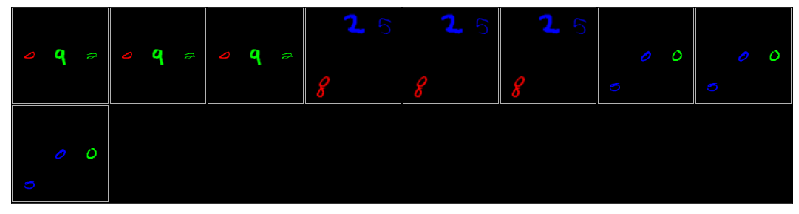

In [30]:
show(img, plot_grid=True, figsize=(14,14))

In [31]:
txt

tensor([[ 0, 10, 14, 18,  9, 11, 15, 18,  2, 10, 15, 18],
        [ 8, 12, 14, 19,  2, 12, 16, 17,  5, 11, 16, 17],
        [ 5, 10, 16, 19,  0, 10, 16, 18,  0, 10, 15, 18],
        [ 0, 10, 14, 18,  9, 11, 15, 18,  2, 10, 15, 18],
        [ 8, 12, 14, 19,  2, 12, 16, 17,  5, 11, 16, 17],
        [ 5, 10, 16, 19,  0, 10, 16, 18,  0, 10, 15, 18],
        [ 0, 10, 14, 18,  9, 11, 15, 18,  2, 10, 15, 18],
        [ 8, 12, 14, 19,  2, 12, 16, 17,  5, 11, 16, 17],
        [ 5, 10, 16, 19,  0, 10, 16, 18,  0, 10, 15, 18]], device='cuda:0')

In [32]:
match_labels

tensor([1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [35]:
img_model = ImgEncoder(
    img_height=128,
    img_width=128,
    img_channels=3,
    patch_height=8,
    patch_width=8,
    embed_dim=128,
    num_blocks=8,
    hidden_dim=256,
    n_attn_heads=8,
    dropout_prob=0.1,
    device=DEVICE
)

txt_model = TxtEncoder(
    txt_max_length=12,
    txt_vocab_size=20,
    embed_dim=128,
    num_blocks=8,
    hidden_dim=256,
    n_attn_heads=8,
    dropout_prob=0.1,
    device=DEVICE
)

In [41]:
img_model(img).shape

torch.Size([8, 128])

In [39]:
txt_model(txt).shape

tensor([[ 0.3881, -1.0857,  0.2033,  ...,  1.0149,  1.0558,  1.0110],
        [-0.5260, -0.2432,  0.6382,  ...,  0.3559,  1.2508,  0.7759],
        [ 0.2997, -0.8272,  0.0409,  ...,  0.8161,  1.3374,  0.7293],
        ...,
        [ 0.6744, -0.6060,  0.6411,  ...,  1.3241,  1.5751,  0.9542],
        [ 0.4245, -0.6248,  0.3086,  ...,  1.0675,  1.0850,  0.3590],
        [ 0.3884, -0.1375,  0.1650,  ...,  1.4206,  0.3953,  0.5591]],
       device='cuda:0', grad_fn=<SliceBackward>)

In [2]:
config_dir_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/'
config_path = config_dir_path + 'matcher_mnistmd_v256_ds3.yaml'
CONFIG = ConfigReader(config_path=config_path)

CONFIG.BATCH_SIZE = 128

CONFIG.print_config_info()

BATCH_SIZE                              128                                     
DEVICE                                  cuda                                    
LR                                      0.01                                    
LR_gamma                                0.1                                     
NUM_EPOCHS                              100                                     
config_path                             /u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/matcher_mnistmd_v256_ds3.yaml
dataset                                 mnist                                   
dataset_type                            md                                      
hidden_dim                              256                                     
in_channels                             3                                       
num_resids_bottleneck                   4                                       
num_resids_downsample                   4                                  

In [3]:
data_source = MNISTData(
    img_type=CONFIG.dataset_type,
    root_path=CONFIG.root_path,
    batch_size=CONFIG.BATCH_SIZE)

train_loader = data_source.get_train_loader(8)

In [4]:
# dvae = DVAE(
#     in_channels=CONFIG.in_channels,
#     vocab_size=CONFIG.vocab_size,
#     num_x2downsamples=CONFIG.num_x2downsamples,
#     num_resids_downsample=CONFIG.num_resids_downsample,
#     num_resids_bottleneck=CONFIG.num_resids_bottleneck,
#     hidden_dim=CONFIG.hidden_dim,
#     device=CONFIG.DEVICE)

# dvae.eval()
# dvae.load_model(
#     root_path=CONFIG.vae_model_path,
#     model_name=CONFIG.vae_model_name)

In [5]:
model = TrMatcher(
    img_height=128,
    img_width=128,
    img_channels=3,
    patch_height=8,
    patch_width=8,
    txt_max_length=12,
    txt_vocab_size=20,
    embed_dim=128,
    num_blocks=8,
    hidden_dim=256,
    n_attn_heads=8,
    dropout_prob=0.1,
    tr_norm_first=False,
    out_dim=1,
    sigmoid_output=True)

# model = TrMatcher(
#     img_height=16,
#     img_width=16,
#     img_embed_dim=CONFIG.vocab_size,
#     txt_max_length=12,
#     txt_vocab_size=20,
#     embed_dim=64,
#     num_blocks=8,
#     hidden_dim=256,
#     n_attn_heads=4,
#     dropout_prob=0.1,
#     out_dim=1,
#     sigmoid_output=True)

model.to(CONFIG.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=CONFIG.LR)

In [6]:
iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for batch_index, (img, txt) in enumerate(train_loader):
        current_batch_size = img.size(0)

        img = img.repeat_interleave(current_batch_size, dim=0)
        txt = txt.repeat(current_batch_size, 1)
        match_labels = torch.eye(current_batch_size).flatten()

        img = img.to(CONFIG.DEVICE)
        txt = txt.permute(1, 0).to(CONFIG.DEVICE)
        match_labels = match_labels.to(CONFIG.DEVICE)

        #with torch.no_grad():
        #    latent = dvae.ng_q_encode(img)
        #b, emb, h, w = latent.size()
        #x = latent.view(b, emb, -1).permute(2, 0, 1)
        
        pred_labels = model(img, txt, average_cls_token=False)

        loss = F.binary_cross_entropy(pred_labels, match_labels)
        loss.backward()
        
        if iteration % 50 == 0:
            print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))

        optimizer.step()
        optimizer.zero_grad()
        
        iteration += 1

Epoch: 0 Iter: 0 Loss: 0.55112
Epoch: 0 Iter: 50 Loss: 0.37697
Epoch: 0 Iter: 100 Loss: 0.37996
Epoch: 0 Iter: 150 Loss: 0.37644
Epoch: 0 Iter: 200 Loss: 0.38036
Epoch: 0 Iter: 250 Loss: 0.376
Epoch: 0 Iter: 300 Loss: 0.37223
Epoch: 0 Iter: 350 Loss: 0.37597
Epoch: 0 Iter: 400 Loss: 0.37903
Epoch: 0 Iter: 450 Loss: 0.38303
Epoch: 0 Iter: 500 Loss: 0.37737
Epoch: 0 Iter: 550 Loss: 0.37429
Epoch: 0 Iter: 600 Loss: 0.37636


KeyboardInterrupt: 

In [8]:
pred_labels

tensor([0.1454, 0.1306, 0.1358, 0.1429, 0.1619, 0.1122, 0.1368, 0.1254, 0.1270,
        0.1086, 0.1373, 0.1711, 0.1319, 0.1270, 0.1272, 0.1345, 0.1652, 0.1278,
        0.1094, 0.1372, 0.1319, 0.1324, 0.1350, 0.1430, 0.1163, 0.1160, 0.1286,
        0.1208, 0.1077, 0.1301, 0.1271, 0.1276, 0.1161, 0.1098, 0.1461, 0.1445,
        0.1340, 0.1228, 0.1529, 0.1813, 0.1229, 0.1085, 0.1119, 0.1294, 0.1605,
        0.1381, 0.1522, 0.1180, 0.1593, 0.1333, 0.1289, 0.1302, 0.1335, 0.1096,
        0.1332, 0.1262, 0.1329, 0.1427, 0.1345, 0.1250, 0.1099, 0.1349, 0.1246,
        0.1094], device='cuda:0', grad_fn=<SigmoidBackward>)

In [38]:
# iteration = 0
# for epoch in range(CONFIG.NUM_EPOCHS):
#     for batch_index, (img, txt) in enumerate(train_loader):
#         current_batch_size = img.size(0)
#         n_true = current_batch_size // 2
#         true_txt = txt[:n_true, :]
#         false_txt = txt[n_true:, :]
#         false_txt = torch.cat((false_txt[[-1], :], false_txt[:-1, :]), dim=0)
#         txt = torch.cat((true_txt, false_txt), dim=0)

#         match_labels = torch.zeros(current_batch_size)
#         match_labels[:n_true] = 1.0

#         img = img.to(CONFIG.DEVICE)
#         txt = txt.permute(1, 0).to(CONFIG.DEVICE)
#         match_labels = match_labels.to(CONFIG.DEVICE)

#         #with torch.no_grad():
#         #    latent = dvae.ng_q_encode(img)
#         #b, emb, h, w = latent.size()
#         #x = latent.view(b, emb, -1).permute(2, 0, 1)
        
#         pred_labels = model(img, txt)

#         loss = F.binary_cross_entropy(pred_labels, match_labels)
#         loss.backward()
        
#         if iteration % 100 == 0:
#             print("Epoch: {} Iter: {} Loss: {}".format(epoch, iteration, round(loss.item(), 5)))

#         optimizer.step()
#         optimizer.zero_grad()
        
#         iteration += 1

In [17]:
img, txt = next(iter(train_loader))

In [32]:
img_all = img.repeat_interleave(4, dim=0)

img_all.shape

torch.Size([16, 3, 128, 128])

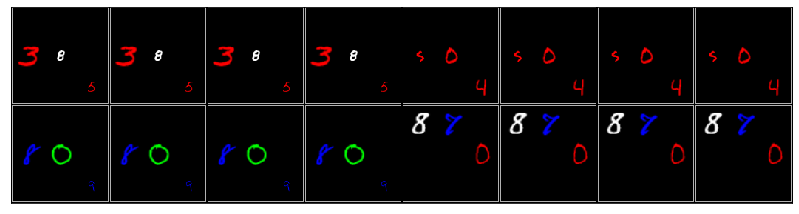

In [33]:
show(img_all, plot_grid=True, figsize=(14,14))

In [36]:
txt.repeat(4, 1)

tensor([[ 3, 12, 14, 18,  8, 10, 13, 18,  5, 10, 14, 19],
        [ 5, 10, 14, 18,  0, 11, 14, 18,  4, 11, 14, 19],
        [ 8, 12, 16, 18,  0, 12, 15, 18,  9, 10, 16, 19],
        [ 8, 12, 13, 17,  7, 12, 16, 17,  0, 12, 14, 18],
        [ 3, 12, 14, 18,  8, 10, 13, 18,  5, 10, 14, 19],
        [ 5, 10, 14, 18,  0, 11, 14, 18,  4, 11, 14, 19],
        [ 8, 12, 16, 18,  0, 12, 15, 18,  9, 10, 16, 19],
        [ 8, 12, 13, 17,  7, 12, 16, 17,  0, 12, 14, 18],
        [ 3, 12, 14, 18,  8, 10, 13, 18,  5, 10, 14, 19],
        [ 5, 10, 14, 18,  0, 11, 14, 18,  4, 11, 14, 19],
        [ 8, 12, 16, 18,  0, 12, 15, 18,  9, 10, 16, 19],
        [ 8, 12, 13, 17,  7, 12, 16, 17,  0, 12, 14, 18],
        [ 3, 12, 14, 18,  8, 10, 13, 18,  5, 10, 14, 19],
        [ 5, 10, 14, 18,  0, 11, 14, 18,  4, 11, 14, 19],
        [ 8, 12, 16, 18,  0, 12, 15, 18,  9, 10, 16, 19],
        [ 8, 12, 13, 17,  7, 12, 16, 17,  0, 12, 14, 18]])

In [42]:
torch.eye(4).flatten()

tensor([1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.])

In [13]:
current_batch_size = img.size(0)
n_true = current_batch_size // 2
true_txt = txt[:n_true, :]
false_txt = txt[n_true:, :]
false_txt = torch.cat((false_txt[[-1], :], false_txt[:-1, :]), dim=0)
txt_new = torch.cat((true_txt, false_txt), dim=0)

In [8]:
txt

tensor([[ 7, 10, 13, 18,  2, 11, 14, 18,  5, 10, 15, 19],
        [ 0, 11, 16, 19,  3, 12, 14, 17,  2, 11, 16, 17],
        [ 0, 11, 13, 19,  6, 12, 16, 19,  1, 12, 16, 18],
        [ 4, 11, 16, 19,  7, 12, 13, 17,  8, 10, 13, 19],
        [ 4, 11, 16, 17,  8, 12, 14, 19,  1, 10, 15, 19],
        [ 9, 12, 16, 18,  9, 12, 16, 18,  4, 10, 15, 18]])

In [15]:
txt_new

tensor([[ 2, 10, 13, 18,  2, 12, 13, 19,  6, 11, 16, 19],
        [ 3, 12, 13, 17,  5, 12, 16, 17,  3, 12, 14, 18],
        [ 2, 12, 16, 18,  5, 11, 15, 17,  5, 10, 16, 18],
        [ 3, 10, 14, 18,  1, 11, 13, 17,  2, 11, 16, 17],
        [ 3, 11, 14, 18,  7, 10, 14, 19,  0, 12, 13, 18],
        [ 3, 11, 14, 19,  6, 12, 14, 17,  2, 11, 16, 19]])